<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep features via k-means

The following notebook is based on the following paper 
https://www-cs.stanford.edu/~acoates/papers/coatesng_nntot2012.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
import os
import sys

import numpy as np
import pandas as pd

import scipy.stats as sstats

from sklearn import datasets
import sklearn.linear_model

from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt

import httpimport


In [3]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

In [4]:
with np.load('cifar.npz') as data:
    cifar_train_data = data['train_data']
    cifar_train_labels = data['train_labels']
    cifar_test_data = data['test_data']
    cifar_test_labels = data['test_labels']



In [5]:
# let's load data 
#(X_trn, y_trn), (X_tst, y_tst) = cifar10.load_data()
X_trn = cifar_train_data
y_trn = cifar_train_labels
X_tst = cifar_test_data
y_tst = cifar_test_labels


In [6]:
X_trn.shape

(50000, 32, 32, 3)

In [7]:
X_tst.shape

(10000, 32, 32, 3)

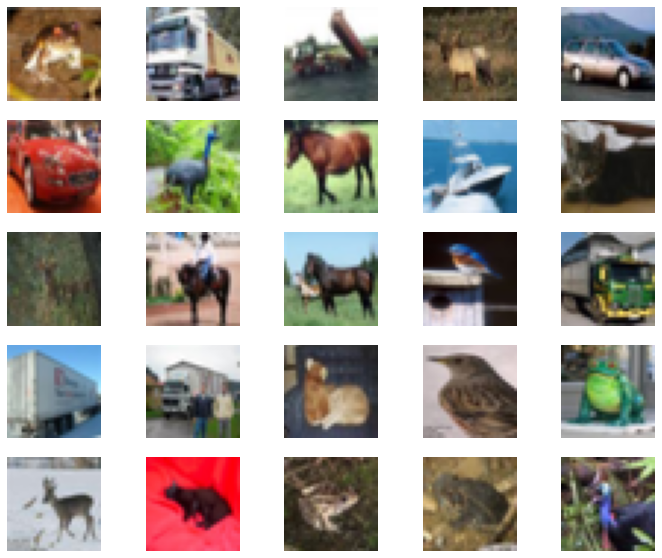

In [8]:
plt.figure(figsize=(12,10))
for xx in range(25):
    plt.subplot(5,5,xx+1)
    plt.imshow(X_trn[xx, :].reshape(32,32,3))
    plt.axis('off')
    

# Simple Logistic Regression

In [9]:
X_trn_norm = (X_trn.reshape(-1,32*32*3) - X_trn.reshape(-1,32*32*3).mean(axis=0))/X_trn.reshape(-1,32*32*3).std(axis=0)
X_tst_norm = (X_tst.reshape(-1,32*32*3) - X_trn.reshape(-1,32*32*3).mean(axis=0))/X_trn.reshape(-1,32*32*3).std(axis=0)

In [10]:
X_trn_norm.shape

(50000, 3072)

In [11]:
from sklearn.linear_model import LogisticRegression

clf_simple = LogisticRegression(random_state=0, max_iter=100, verbose=True, n_jobs=6).fit(X_trn_norm, y_trn.flatten())



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  1.6min finished


In [12]:
y_trn_pred = clf_simple.predict(X_trn_norm)
print((y_trn.flatten() == y_trn_pred).mean())

0.46202


In [13]:
y_tst_pred = clf_simple.predict(X_tst_norm)
print((y_tst.flatten() == y_tst_pred).mean())

0.3979


# Deep Features

## find important patterns in patches

In [14]:
def contrast(image):
  return (image-image.min())/(image.max() - image.min())

In [15]:
def normalize_patch(patch, eps=10):
  return (patch - patch.mean())/np.sqrt(patch.var() + eps)


In [16]:
def whiten(X):
  X_norm = (X - X.mean(axis=0))/X.std(axis=0)
  cov = np.cov(X_norm, rowvar=False) 
  U,S,V = np.linalg.svd(cov)
  
  #zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
  X_zca = U.dot(np.diag(1.0/np.sqrt(S + 0.1))).dot(U.T).dot(X_norm.T).T
  return X_zca

In [17]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()

### Let's get some intuition for what whitening does

In [18]:
X_zca = whiten(X_trn[:1000].reshape(-1,32*32*3))

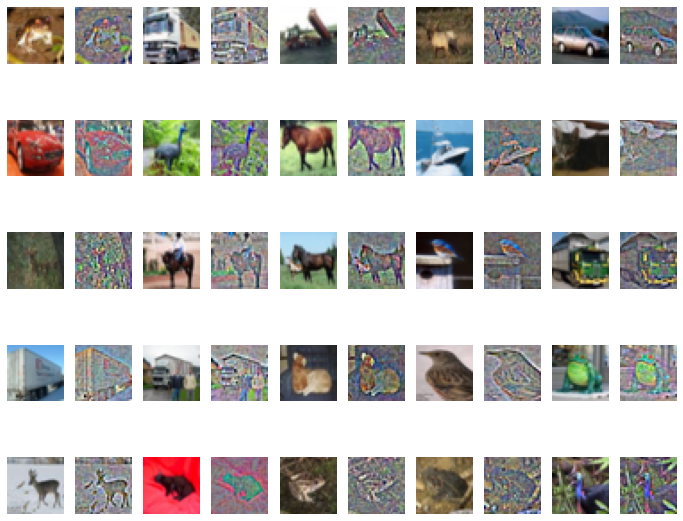

In [19]:
plt.figure(figsize=(12,10))
for xx in range(25):
    plt.subplot(5,10,2*xx+1)
    plt.imshow(X_trn[xx, :].reshape(32,32,3))
    plt.axis('off')
    plt.subplot(5,10,2*xx+2)
    plt.imshow(contrast(X_zca[xx, :]).reshape(32,32,3))
    plt.axis('off')
    

### Back to the feature extraction

In [20]:
def normalize_patch(patch, eps=10):
  return (patch - patch.mean())/np.sqrt(patch.var() + eps)

In [21]:
PATCH_SIZE = 8
patch_num = 100000
STRIDE = 8


In [22]:
X_trn.shape

(50000, 32, 32, 3)

In [23]:
patches = []
for i in range(patch_num):
  for r in range(32-PATCH_SIZE+1):
    for c in range(32-PATCH_SIZE+1):
      patch = X_trn[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
      patch_norm = normalize_patch(patch, eps=10)
      patches.append(patch_norm)
  if len(patches) >= patch_num:
    break   

In [24]:
P = np.vstack(patches)
P.shape

(100000, 192)

In [25]:
P_zca = whiten(P)

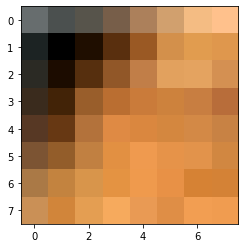

In [26]:
plt.imshow(contrast(P[0].reshape(PATCH_SIZE, PATCH_SIZE, 3)))

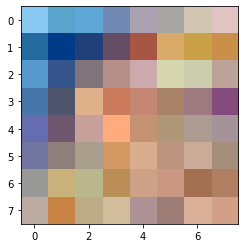

In [27]:
plt.imshow(contrast(P_zca[0].reshape(PATCH_SIZE, PATCH_SIZE, 3)))

In [28]:
kroot = 16
k = kroot*kroot

In [29]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, verbose=True, n_init=1, max_iter=200, batch_size=10000).fit(P_zca)
kmeans.labels_
kmeans.cluster_centers_


Init 1/1 with method k-means++
Inertia for init 1/1: 2109499.9754000492
[MiniBatchKMeans] Reassigning 139 cluster centers.
Minibatch step 1/2000: mean batch inertia: 70.7080703447131
[MiniBatchKMeans] Reassigning 110 cluster centers.
Minibatch step 2/2000: mean batch inertia: 65.17018131669272, ewa inertia: 65.17018131669272
[MiniBatchKMeans] Reassigning 93 cluster centers.
Minibatch step 3/2000: mean batch inertia: 63.670550274599904, ewa inertia: 64.87025810750625
[MiniBatchKMeans] Reassigning 72 cluster centers.
Minibatch step 4/2000: mean batch inertia: 62.910234705244214, ewa inertia: 64.47825734706144
[MiniBatchKMeans] Reassigning 61 cluster centers.
Minibatch step 5/2000: mean batch inertia: 62.88490074294384, ewa inertia: 64.15958921291926
[MiniBatchKMeans] Reassigning 54 cluster centers.
Minibatch step 6/2000: mean batch inertia: 61.275135558196226, ewa inertia: 63.58270425082427
[MiniBatchKMeans] Reassigning 47 cluster centers.
Minibatch step 7/2000: mean batch inertia: 61.61

array([[-0.7420887 ,  0.12057546,  0.51937191, ..., -0.08523162,
         0.00797352,  0.05768645],
       [ 0.37718515,  0.43146144,  0.3796663 , ...,  0.05250999,
         0.08430437,  0.10166177],
       [ 0.05196916,  0.06773251,  0.07508605, ...,  0.02675208,
         0.00409205, -0.00874966],
       ...,
       [ 0.04172806,  0.06818469,  0.19536284, ...,  0.04592895,
         0.08665942, -0.043457  ],
       [-0.09402851, -0.13701554, -0.12147064, ...,  0.01175114,
        -0.01079738, -0.038617  ],
       [ 0.65126127, -0.6340046 , -1.13409332, ..., -0.1388568 ,
         0.04309452,  0.23013285]])

In [30]:
filters_final = kmeans.cluster_centers_
filters_final.shape

(256, 192)

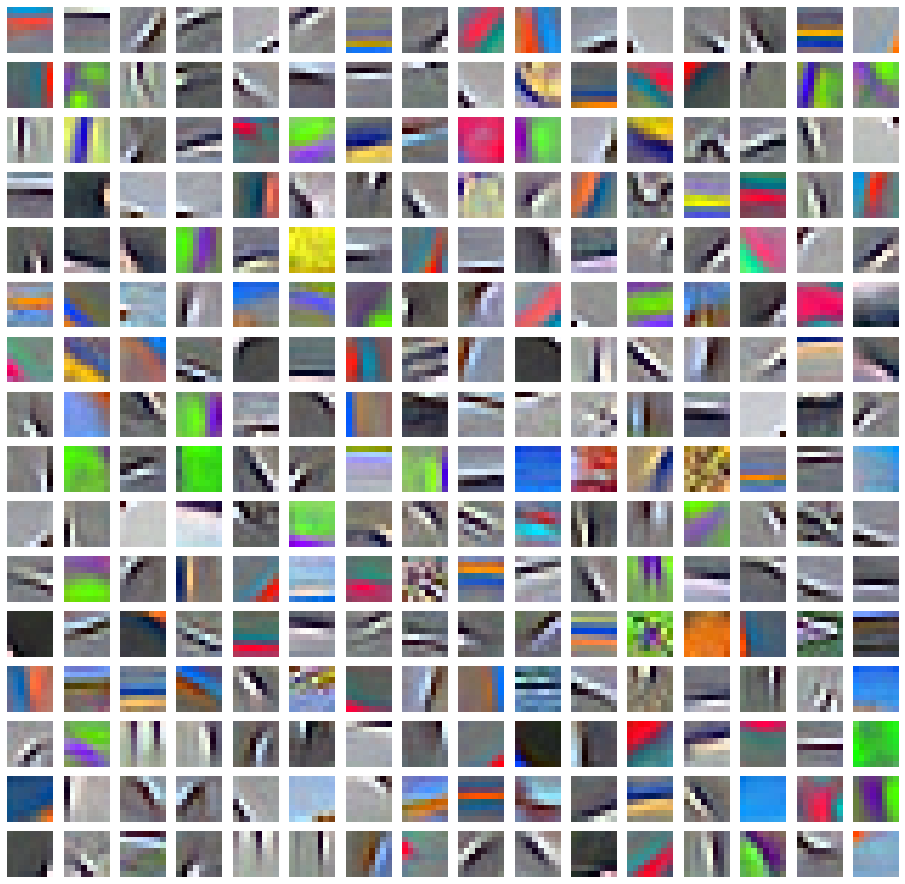

In [31]:
plt.figure(figsize=(kroot,kroot))
for xx in range(k):
    plt.subplot(kroot,kroot,xx+1)
    plt.imshow((contrast(filters_final[xx])).reshape(PATCH_SIZE, PATCH_SIZE, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    

# transform dataset according to the patterns found in patches




In [32]:
def dist(x,y):
  return np.sqrt((x - y).dot(x-y))
  #return (x-y).dot(x-y)
    
def create_patch_features(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
      if i % 1000 == 0:
        print(i,"/", X.shape[0])
        
      mapped_features = []
      for r in range(0, 32-PATCH_SIZE+1, STRIDE):
        for c in range(0, 32-PATCH_SIZE+1, STRIDE):
          patch = X[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
          patch_norm = normalize_patch(patch, eps=0.01)
          mapped_features.append([dist(patch_norm, f) for f in filters_final])
      X_mapped_list_per_image.append(np.vstack(mapped_features))
    X_mapped = np.asarray(X_mapped_list_per_image).reshape(-1, ((32-PATCH_SIZE)//STRIDE+1)**2*filters_final.shape[0])
    return X_mapped

In [33]:
from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def create_patch_features__vectorized(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
        if i % 5000 == 0:
            print(i,"/", X.shape[0])
        patches = image.extract_patches_2d(X[i], (PATCH_SIZE, PATCH_SIZE))
        strided_patches = patches.reshape( 32-PATCH_SIZE+1 , 32-PATCH_SIZE+1, PATCH_SIZE, PATCH_SIZE, 3)[::STRIDE,::STRIDE,:,:,:]
        strided_patches = strided_patches.reshape(((32-PATCH_SIZE)//STRIDE+1)**2, PATCH_SIZE * PATCH_SIZE * 3)
        mapped_features = euclidean_distances(np.asarray([normalize_patch(patch, eps=0.01) for patch in strided_patches]), filters_final)
        X_mapped_list_per_image.append(mapped_features.reshape(((32-PATCH_SIZE)//STRIDE+1)**2 * filters_final.shape[0]))
    X_mapped = np.asarray(X_mapped_list_per_image)
    return X_mapped

In [34]:
X_mapped_trn = create_patch_features__vectorized(X_trn)

0 / 50000
5000 / 50000
10000 / 50000
15000 / 50000
20000 / 50000
25000 / 50000
30000 / 50000
35000 / 50000
40000 / 50000
45000 / 50000


In [35]:
X_mapped_trn.shape

(50000, 4096)

In [36]:
X_mapped_tst = create_patch_features__vectorized(X_tst)

0 / 10000
5000 / 10000


In [37]:
X_mapped_tst.shape

(10000, 4096)

# Logistic Regression on mapped features

In [38]:
X_mapped_trn_norm = (X_mapped_trn - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)

In [39]:
X_mapped_tst_norm = (X_mapped_tst - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)

In [40]:
X_mapped_trn_norm.std(axis=0).sum()

4095.9999999999995

In [41]:
X_mapped_tst_norm.std(axis=0).sum()

4100.468972566234

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
clf = LogisticRegression(random_state=0, max_iter=100, n_jobs=10, verbose=True).fit(X_mapped_trn_norm, y_trn.flatten())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.9min finished


In [44]:
y_trn_pred = clf.predict(X_mapped_trn_norm)
(y_trn.flatten() == y_trn_pred).mean()

0.54056

In [45]:
y_tst_pred = clf.predict(X_mapped_tst_norm)
(y_tst.flatten() == y_tst_pred).mean()

0.4535